In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
num_samples = 100
sample_range = range(0, 100)

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [ ]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.5, beta=0.2, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [ ]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:50, 16.85s/it]

Converged after 429 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.40s/it]

Converged after 310 outer iterations



Processing Samples:   1%|          | 1/100 [01:36<2:38:35, 96.11s/it]

Converged after 390 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:56<00:57, 19.13s/it]

Converged after 500 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.79s/it]

Converged after 434 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.44s/it]

Converged after 372 outer iterations



Processing Samples:   2%|▏         | 2/100 [03:10<2:35:29, 95.20s/it]

Converged after 309 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:16, 16.90s/it]

Converged after 388 outer iterations



Processing Samples:   3%|▎         | 3/100 [04:53<2:39:21, 98.57s/it]

Converged after 339 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:57<00:56, 18.85s/it]

Converged after 482 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.37s/it]

Converged after 321 outer iterations



Processing Samples:   4%|▍         | 4/100 [06:32<2:37:59, 98.75s/it]

Converged after 285 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:33<01:05, 16.43s/it]

Converged after 419 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:08<00:34, 17.23s/it]

Converged after 490 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.46s/it]

Converged after 307 outer iterations



Processing Samples:   5%|▌         | 5/100 [08:06<2:33:43, 97.09s/it]

Converged after 350 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:56<00:57, 19.11s/it]

Converged after 375 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:14, 14.84s/it]

Converged after 345 outer iterations



Processing Samples:   6%|▌         | 6/100 [09:37<2:29:01, 95.12s/it]

Converged after 267 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:58<00:57, 19.27s/it]

Converged after 454 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.20s/it]

Converged after 400 outer iterations



Processing Samples:   7%|▋         | 7/100 [11:23<2:32:59, 98.70s/it]

Converged after 422 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.46s/it]

Converged after 326 outer iterations



Processing Samples:   8%|▊         | 8/100 [13:06<2:33:16, 99.96s/it]

Converged after 440 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:17<01:27, 17.42s/it]

Converged after 496 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.17s/it]

Converged after 373 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.87s/it]

Converged after 417 outer iterations



Processing Samples:   9%|▉         | 9/100 [14:41<2:29:20, 98.47s/it]

Converged after 347 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:54<00:54, 18.06s/it]

Converged after 457 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.03s/it]

Converged after 427 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:13, 13.93s/it]

Converged after 277 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:18, 18.01s/it]

Converged after 454 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.97s/it]

Converged after 363 outer iterations



Processing Samples:  12%|█▏        | 12/100 [19:50<2:28:55, 101.54s/it]

Converged after 346 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:51, 17.08s/it]

Converged after 454 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.23s/it]

Converged after 402 outer iterations



Processing Samples:  13%|█▎        | 13/100 [21:26<2:24:53, 99.93s/it] 

Converged after 294 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:32<01:04, 16.17s/it]

Converged after 425 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:36, 18.27s/it]

Converged after 487 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.68s/it]

Converged after 360 outer iterations



Processing Samples:  14%|█▍        | 14/100 [23:09<2:24:25, 100.76s/it]

Converged after 489 outer iterations



Processing Samples:  15%|█▌        | 15/100 [24:54<2:24:44, 102.18s/it]

Converged after 368 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.15s/it]

Converged after 457 outer iterations



Processing Samples:  16%|█▌        | 16/100 [26:37<2:23:30, 102.50s/it]

Converged after 316 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.51s/it]

Converged after 459 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.67s/it]

Converged after 402 outer iterations



Processing Samples:  17%|█▋        | 17/100 [28:19<2:21:35, 102.36s/it]

Converged after 422 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:55<00:54, 18.14s/it]

Converged after 481 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.87s/it]

Converged after 409 outer iterations



Processing Samples:  18%|█▊        | 18/100 [30:01<2:19:45, 102.26s/it]

Converged after 361 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.08s/it]

Converged after 383 outer iterations



Processing Samples:  19%|█▉        | 19/100 [31:48<2:19:56, 103.66s/it]

Converged after 494 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.25s/it]

Converged after 420 outer iterations



Processing Samples:  20%|██        | 20/100 [33:31<2:17:52, 103.41s/it]

Converged after 338 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.44s/it]

Converged after 312 outer iterations



Processing Samples:  21%|██        | 21/100 [35:06<2:12:46, 100.84s/it]

Converged after 280 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.72s/it]

Converged after 478 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.25s/it]

Converged after 366 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.58s/it]

Converged after 386 outer iterations



Processing Samples:  23%|██▎       | 23/100 [38:36<2:11:19, 102.34s/it]

Converged after 449 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:39<01:17, 19.34s/it]

Converged after 496 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:56<00:55, 18.47s/it]

Converged after 497 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.66s/it]

Converged after 378 outer iterations



Processing Samples:  24%|██▍       | 24/100 [40:20<2:10:02, 102.67s/it]

Converged after 417 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.15s/it]

Converged after 417 outer iterations



Processing Samples:  25%|██▌       | 25/100 [42:02<2:08:19, 102.67s/it]

Converged after 356 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.47s/it]

Converged after 440 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.90s/it]

Converged after 471 outer iterations



Processing Samples:  26%|██▌       | 26/100 [43:43<2:05:51, 102.05s/it]

Converged after 297 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.06s/it]

Converged after 456 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.36s/it]

Converged after 490 outer iterations



Processing Samples:  27%|██▋       | 27/100 [45:34<2:07:31, 104.81s/it]

Converged after 423 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:52<00:51, 17.29s/it]

Converged after 477 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.01s/it]

Converged after 351 outer iterations



Processing Samples:  28%|██▊       | 28/100 [47:10<2:02:22, 101.98s/it]

Converged after 302 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.91s/it]

Converged after 454 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.52s/it]

Converged after 380 outer iterations



Processing Samples:  29%|██▉       | 29/100 [48:43<1:57:48, 99.55s/it] 

Converged after 273 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:11<00:33, 16.95s/it]

Converged after 375 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.56s/it]

Converged after 443 outer iterations



Processing Samples:  30%|███       | 30/100 [50:25<1:56:47, 100.11s/it]

Converged after 385 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:32<01:04, 16.10s/it]

Converged after 417 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.36s/it]

Converged after 355 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.78s/it]

Converged after 368 outer iterations



Processing Samples:  31%|███       | 31/100 [51:53<1:51:09, 96.66s/it] 

Converged after 282 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.56s/it]

Converged after 429 outer iterations



Processing Samples:  32%|███▏      | 32/100 [53:30<1:49:37, 96.72s/it]

Converged after 287 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.66s/it]

Converged after 481 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.32s/it]

Converged after 470 outer iterations



Processing Samples:  33%|███▎      | 33/100 [55:14<1:50:17, 98.77s/it]

Converged after 380 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:32, 16.39s/it]

Converged after 352 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.45s/it]

Converged after 370 outer iterations



Processing Samples:  34%|███▍      | 34/100 [56:50<1:47:41, 97.91s/it]

Converged after 352 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:34<01:07, 16.90s/it]

Converged after 453 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.97s/it]

Converged after 382 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.19s/it]

Converged after 469 outer iterations



Processing Samples:  35%|███▌      | 35/100 [58:25<1:45:19, 97.22s/it]

Converged after 334 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:15<01:16, 15.21s/it]

Converged after 411 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:48, 16.25s/it]

Converged after 443 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:33, 16.65s/it]

Converged after 488 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.93s/it]

Converged after 396 outer iterations



Processing Samples:  36%|███▌      | 36/100 [59:58<1:42:05, 95.70s/it]

Converged after 286 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.10s/it]

Converged after 471 outer iterations



Processing Samples:  37%|███▋      | 37/100 [1:01:43<1:43:27, 98.54s/it]

Converged after 400 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:53<00:53, 17.79s/it]

Converged after 429 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.40s/it]

Converged after 407 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.70s/it]

Converged after 407 outer iterations



Processing Samples:  38%|███▊      | 38/100 [1:03:23<1:42:13, 98.93s/it]

Converged after 453 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.22s/it]

Converged after 469 outer iterations



Processing Samples:  39%|███▉      | 39/100 [1:05:09<1:42:47, 101.10s/it]

Converged after 414 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.78s/it]

Converged after 427 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.84s/it]

Converged after 376 outer iterations



Processing Samples:  40%|████      | 40/100 [1:06:43<1:39:09, 99.15s/it] 

Converged after 304 outer iterations



Processing Samples:  41%|████      | 41/100 [1:08:30<1:39:51, 101.55s/it]

Converged after 439 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.62s/it]

Converged after 475 outer iterations



Processing Samples:  43%|████▎     | 43/100 [1:12:03<1:38:33, 103.75s/it]

Converged after 380 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:54<00:52, 17.46s/it]

Converged after 437 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.57s/it]

Converged after 309 outer iterations



Processing Samples:  44%|████▍     | 44/100 [1:13:41<1:35:20, 102.14s/it]

Converged after 390 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.76s/it]

Converged after 343 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.40s/it]

Converged after 402 outer iterations



Processing Samples:  45%|████▌     | 45/100 [1:15:13<1:30:48, 99.07s/it] 

Converged after 286 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:50<00:50, 16.78s/it]

Converged after 447 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.22s/it]

Converged after 420 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.70s/it]

Converged after 410 outer iterations



Processing Samples:  46%|████▌     | 46/100 [1:16:53<1:29:25, 99.35s/it]

Converged after 448 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:31, 15.96s/it]

Converged after 363 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.11s/it]

Converged after 359 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:18:28<1:26:32, 97.98s/it]

Converged after 409 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:35<01:10, 17.56s/it]

Converged after 464 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.42s/it]

Converged after 499 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.74s/it]

Converged after 466 outer iterations



Processing Samples:  48%|████▊     | 48/100 [1:20:10<1:26:00, 99.24s/it]

Converged after 322 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.64s/it]

Converged after 421 outer iterations
Converged after 345 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.40s/it]

Converged after 363 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:23:27<1:22:22, 98.86s/it]

Converged after 271 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:53<00:54, 18.10s/it]

Converged after 493 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.03s/it]

Converged after 449 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.79s/it]

Converged after 401 outer iterations



Processing Samples:  51%|█████     | 51/100 [1:25:03<1:19:56, 97.88s/it]

Converged after 324 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.30s/it]

Converged after 447 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.45s/it]

Converged after 311 outer iterations



Processing Samples:  52%|█████▏    | 52/100 [1:26:42<1:18:40, 98.35s/it]

Converged after 436 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.93s/it]

Converged after 457 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.61s/it]

Converged after 463 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:28:22<1:17:21, 98.76s/it]

Converged after 361 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:49, 16.54s/it]

Converged after 408 outer iterations



Processing Samples:  54%|█████▍    | 54/100 [1:30:01<1:15:49, 98.89s/it]

Converged after 358 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.76s/it]

Converged after 382 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.68s/it]

Converged after 371 outer iterations



Processing Samples:  55%|█████▌    | 55/100 [1:31:32<1:12:25, 96.57s/it]

Converged after 280 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:55<00:53, 17.93s/it]

Converged after 474 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.58s/it]

Converged after 480 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.31s/it]

Converged after 380 outer iterations



Processing Samples:  56%|█████▌    | 56/100 [1:33:15<1:12:07, 98.35s/it]

Converged after 456 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.09s/it]

Converged after 429 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:37<01:16, 19.11s/it]

Converged after 480 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.49s/it]

Converged after 459 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.57s/it]

Converged after 313 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.07s/it]

Converged after 471 outer iterations



Processing Samples:  59%|█████▉    | 59/100 [1:38:27<1:09:42, 102.01s/it]

Converged after 432 outer iterations



Processing Samples:  60%|██████    | 60/100 [1:40:10<1:08:19, 102.49s/it]

Converged after 358 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:55<00:56, 18.79s/it]

Converged after 391 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.42s/it]

Converged after 413 outer iterations



Processing Samples:  61%|██████    | 61/100 [1:41:42<1:04:27, 99.17s/it] 

Converged after 259 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:13<01:08, 13.75s/it]

Converged after 373 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:27<00:53, 13.46s/it]

Converged after 356 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:40<00:40, 13.59s/it]

Converged after 369 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.80s/it]

Converged after 384 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:14, 14.57s/it]

Converged after 447 outer iterations



Processing Samples:  62%|██████▏   | 62/100 [1:43:04<59:36, 94.12s/it]  

Converged after 319 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.17s/it]

Converged after 378 outer iterations



Processing Samples:  63%|██████▎   | 63/100 [1:44:40<58:22, 94.66s/it]

Converged after 303 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:31, 15.69s/it]

Converged after 366 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.90s/it]

Converged after 386 outer iterations



Processing Samples:  64%|██████▍   | 64/100 [1:46:13<56:29, 94.16s/it]

Converged after 351 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.47s/it]

Converged after 369 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [1:47:52<55:51, 95.76s/it]

Converged after 342 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.87s/it]

Converged after 450 outer iterations



Processing Samples:  66%|██████▌   | 66/100 [1:49:35<55:29, 97.91s/it]

Converged after 357 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:50<00:49, 16.57s/it]

Converged after 428 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.45s/it]

Converged after 456 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.60s/it]

Converged after 475 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.38s/it]

Converged after 466 outer iterations



Processing Samples:  68%|██████▊   | 68/100 [1:52:59<53:06, 99.58s/it]

Converged after 315 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.06s/it]

Converged after 432 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.28s/it]

Converged after 411 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [1:54:38<51:27, 99.60s/it]

Converged after 372 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:50<00:49, 16.59s/it]

Converged after 436 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.32s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.52s/it]

Converged after 378 outer iterations



Processing Samples:  70%|███████   | 70/100 [1:56:15<49:20, 98.67s/it]

Converged after 454 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:20<01:41, 20.23s/it]

Converged after 479 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:35<01:09, 17.38s/it]

Converged after 430 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:50<00:48, 16.05s/it]

Converged after 395 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:27, 13.78s/it]

Converged after 357 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.50s/it]

Converged after 432 outer iterations



Processing Samples:  71%|███████   | 71/100 [1:57:41<45:54, 94.97s/it]

Converged after 256 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:16<01:20, 16.06s/it]

Converged after 453 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.77s/it]

Converged after 335 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.38s/it]

Converged after 358 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.36s/it]

Converged after 475 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.85s/it]

Converged after 427 outer iterations



Processing Samples:  73%|███████▎  | 73/100 [2:00:58<43:31, 96.74s/it]

Converged after 321 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.11s/it]

Converged after 488 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.57s/it]

Converged after 464 outer iterations



Processing Samples:  74%|███████▍  | 74/100 [2:02:49<43:42, 100.88s/it]

Converged after 500 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.40s/it]

Converged after 464 outer iterations



Processing Samples:  75%|███████▌  | 75/100 [2:04:35<42:40, 102.40s/it]

Converged after 417 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.76s/it]

Converged after 336 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [2:06:12<40:19, 100.79s/it]

Converged after 393 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:30<00:59, 14.84s/it]

Converged after 339 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:08<00:35, 17.70s/it]

Converged after 471 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.45s/it]

Converged after 313 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [2:07:40<37:09, 96.92s/it] 

Converged after 264 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:14<01:14, 15.00s/it]

Converged after 412 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:47, 15.81s/it]

Converged after 415 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.79s/it]

Converged after 442 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.58s/it]

Converged after 322 outer iterations



Processing Samples:  78%|███████▊  | 78/100 [2:09:07<34:29, 94.06s/it]

Converged after 289 outer iterations



Processing Samples:  79%|███████▉  | 79/100 [2:10:50<33:50, 96.71s/it]

Converged after 321 outer iterations



Processing Samples:  80%|████████  | 80/100 [2:12:37<33:14, 99.75s/it]

Converged after 430 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:15<01:15, 15.19s/it]

Converged after 418 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:48, 16.13s/it]

Converged after 433 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.12s/it]

Converged after 448 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.64s/it]

Converged after 400 outer iterations



Processing Samples:  81%|████████  | 81/100 [2:14:10<30:58, 97.81s/it]

Converged after 374 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:51, 17.23s/it]

Converged after 469 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.06s/it]

Converged after 396 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.62s/it]

Converged after 407 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:15:42<28:51, 96.17s/it]

Converged after 273 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:31<01:02, 15.64s/it]

Converged after 387 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:35, 18.00s/it]

Converged after 475 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.52s/it]

Converged after 465 outer iterations



Processing Samples:  83%|████████▎ | 83/100 [2:17:22<27:35, 97.37s/it]

Converged after 368 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.60s/it]

Converged after 400 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.74s/it]

Converged after 430 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.03s/it]

Converged after 401 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [2:20:44<24:40, 98.70s/it]

Converged after 344 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.95s/it]

Converged after 413 outer iterations



Processing Samples:  86%|████████▌ | 86/100 [2:22:25<23:09, 99.22s/it]

Converged after 299 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.09s/it]

Converged after 499 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.84s/it]

Converged after 399 outer iterations



Processing Samples:  88%|████████▊ | 88/100 [2:25:54<20:22, 101.84s/it]

Converged after 368 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.20s/it]

Converged after 400 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [2:27:36<18:40, 101.89s/it]

Converged after 351 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.94s/it]

Converged after 439 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.33s/it]

Converged after 314 outer iterations



Processing Samples:  90%|█████████ | 90/100 [2:29:13<16:42, 100.28s/it]

Converged after 415 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.11s/it]

Converged after 396 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.65s/it]

Converged after 439 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:56<00:55, 18.58s/it]

Converged after 486 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.93s/it]

Converged after 397 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:37<01:15, 18.83s/it]

Converged after 472 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:52<00:50, 16.73s/it]

Converged after 386 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.17s/it]

Converged after 394 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [2:34:23<11:54, 102.00s/it]

Converged after 438 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:31, 15.90s/it]

Converged after 369 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.65s/it]

Converged after 419 outer iterations



Processing Samples:  95%|█████████▌| 95/100 [2:37:55<08:39, 103.97s/it]

Converged after 430 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.14s/it]

Converged after 374 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.31s/it]

Converged after 364 outer iterations



Processing Samples:  96%|█████████▌| 96/100 [2:39:29<06:44, 101.24s/it]

Converged after 375 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.73s/it]

Converged after 373 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.27s/it]

Converged after 333 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [2:42:54<03:22, 101.45s/it]

Converged after 311 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:35<01:10, 17.56s/it]

Converged after 498 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.76s/it]

Converged after 431 outer iterations



Processing Samples:  99%|█████████▉| 99/100 [2:44:31<01:40, 100.23s/it]

Converged after 289 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:20<01:41, 20.22s/it]

Converged after 498 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.08s/it]

Converged after 418 outer iterations



Processing Samples: 100%|██████████| 100/100 [2:46:13<00:00, 99.73s/it] 

Converged after 317 outer iterations


In [ ]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [ 53.65  78.2   93.65  98.65  99.85 100.  ]
Avg SRR : [0.27850608 0.47137205 0.72026738 0.93036326 0.99406593 1.        ]
Avg FR  : [2.80526316 2.78157895 1.49210526 0.30526316 0.02105263 0.        ]
Avg PR  : [0.50678674 0.60624939 0.78075945 0.94923622 0.99627706 1.        ]
Avg RE  : [0.5365 0.782  0.9365 0.9865 0.9985 1.    ]
Avg F1  : [0.51943486 0.68104201 0.84865887 0.96654126 0.99733941 1.        ]
Avg NMSE: [0.66278245 0.40895256 0.19967095 0.06430269 0.01987839 0.00748606]


In [ ]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-100-casbl-anc-alpha-1-50-beta-0-20-snr-db-all-pilot-length-30.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


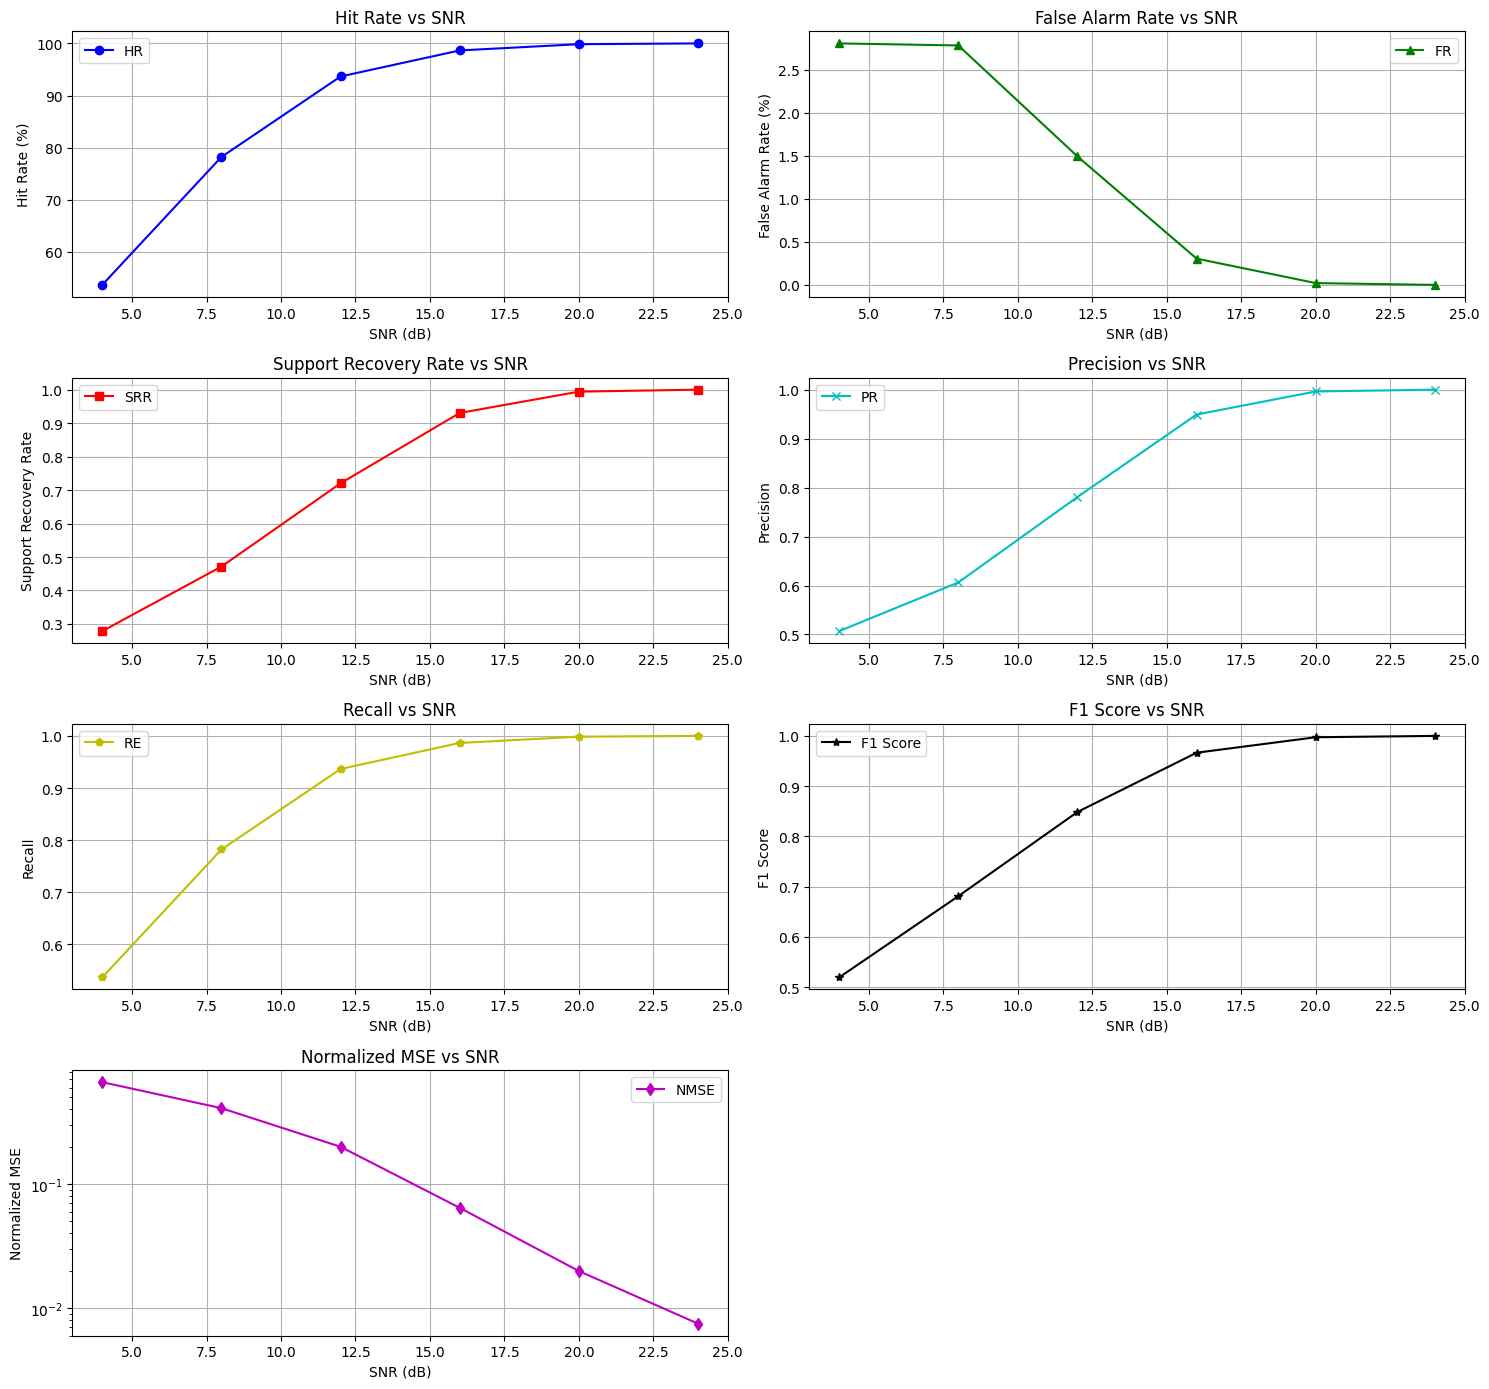

In [ ]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

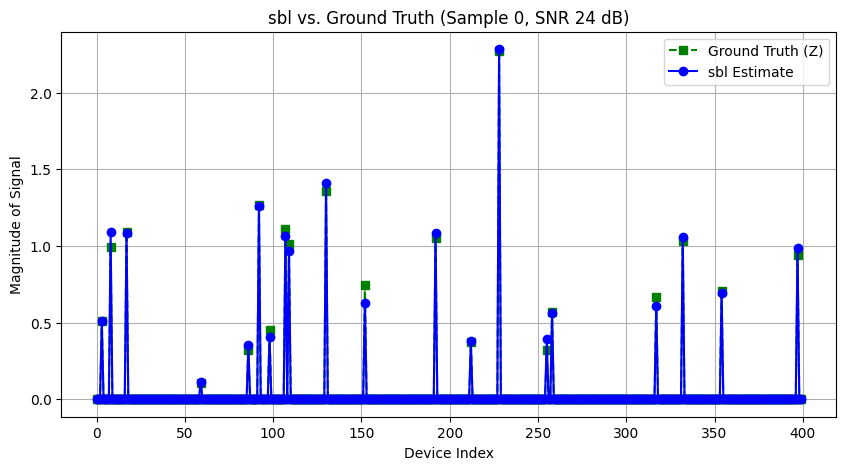

In [ ]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


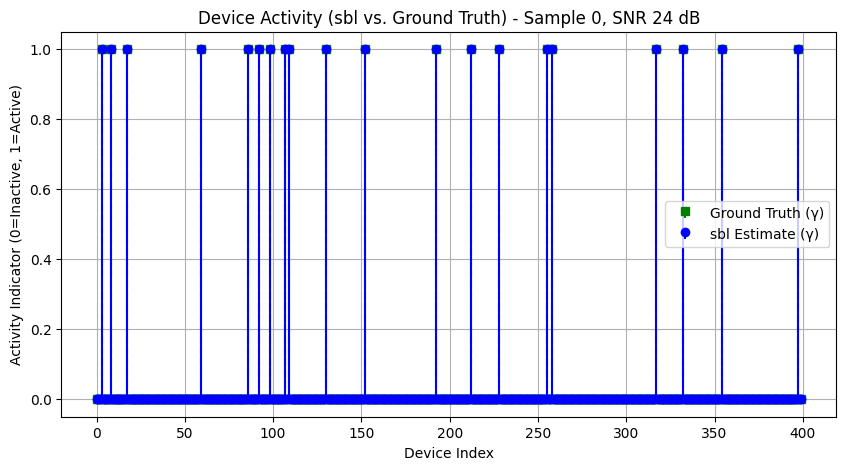

In [ ]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)